In [1]:
# Imports you'll need.
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sys
import os
import time
from TwitterAPI import TwitterAPI
import configparser
from operator import itemgetter, attrgetter
from collections import Counter, defaultdict
import copy
import math
import pickle
import re


In [2]:
Follower_dict= defaultdict(list)

In [3]:
# This method is done for you.
def get_twitter(config_file):
    config = configparser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter


In [4]:
def read_screen_names(filename):
    
    ###TODO
   
    f = open(filename, 'r')
    strings = re.findall(r"\S+", f.read())
    #print(strings)
    
    return(strings)

In [5]:
# I've provided the method below to handle Twitter's rate limiting.
# You should call this method whenever you need to access the Twitter API.
def robust_request(twitter, resource, params, max_tries=5):
    """ If a Twitter request fails, sleep for 15 minutes.
    Do this at most max_tries times before quitting.
    Args:
      twitter .... A TwitterAPI object.
      resource ... A resource string to request; e.g., "Followers/ids"
      params ..... A parameter dict for the request, e.g., to specify
                   parameters like screen_name or count.
      max_tries .. The maximum number of tries to attempt.
    Returns:
      A TwitterResponse object, or None if failed.
    """
    #print('\nIn robust _request')   
    for i in range(max_tries):
        #print('resource=%s' % resource)
        #print('params =%s' % params)
        #print(twitter)
        request = twitter.request(resource,{'screen_name':params})
        
        if request.status_code == 200 :           
            return request
        else:
            print('Got error %s \nsleeping for 15 minutes.' % request.text)
            sys.stderr.flush()
            time.sleep(61 * 15)

In [6]:
def get_users(twitter, screen_names):
    """Retrieve the Twitter user objects for each screen_name.
        Params:
        twitter........The TwitterAPI object.
        screen_names...A list of strings, one per screen_name
    Returns:
        A list of dicts, one per user, containing all the user information
        (e.g., screen_name, id, location, etc)

    See the API documentation here: https://dev.twitter.com/rest/reference/get/users/lookup

    In this example, I test retrieving two users: twitterapi and twitter.

    >>> twitter = get_twitter()
    >>> users = get_users(twitter, ['twitterapi', 'twitter'])
    >>> [u['id'] for u in users]
    [6253282, 783214]
    """
    ###TODO
    list = []
    
    resource= 'users/lookup'
   
    #print('In get User')
    params = [r for r in screen_names]
    #print('Found %d params' % len(params))
    

    request = robust_request(twitter,resource,params)        
    tweets = [r for r in request]
            
    for i in range(len(tweets)) :
        a_tweet = tweets[i]            
        print('\nId=%d, \tScreen_Name=%s, \tName=%s, \tLocation=%s' % (a_tweet['id'],a_tweet['screen_name'],a_tweet['name'], a_tweet['location']))    
        list.append (a_tweet)
        
     
    #print('In Printing List')        
    #for i in range(len(list)):
       #  print(list) 

    return(list)

In [7]:
def get_Followers(twitter, screen_name):
    """ Return a list of Twitter IDs for users that this person follows, up to 5000.
    See https://dev.twitter.com/rest/reference/get/Followers/ids

    Note, because of rate limits, it's best to test this method for one candidate before trying
    on all candidates.

    Args:
        twitter.......The TwitterAPI object
        screen_name... a string of a Twitter screen name
    Returns:
        A list of ints, one per Follower ID, sorted in ascending order.

    Note: If a user follows more than 5000 accounts, we will limit ourselves to
    the first 5000 accounts returned.

    In this test case, I return the first 5 accounts that I follow.
    >>> twitter = get_twitter()
    >>> get_Followers(twitter, 'aronwc')[:5]
    [695023, 1697081, 8381682, 10204352, 11669522]
    """
    ###TODO

    Follower_list =[int]
    #print('\nIn get_Followers') 
    #print(screen_name)
    while True : 
          try:
              request = twitter.request('followers/ids', {'screen_name':screen_name , 'count':500})

              if request.status_code == 200 :  
                 Follower_list = [r for r in request] 
                 #print('\n Help on twitter.request for Followers/ids copied to Follower_list')
                 print('Number of Followers -> %d' % len(Follower_list))
                 #print('Sorting')
                 Follower_list.sort()
                 #print('Sorted Follower List of Screen_Name %s ->%s' % (screen_name,Follower_list))
                 return(Follower_list)

              if request.status_code == 429 :
                 print('Got error %s \nsleeping for 15 minutes.' % request.text)
                 sys.stderr.flush()
                 time.sleep(61 * 15)

          except:
               print("Unexpected error:", sys.exc_info()[0])

    pass

In [8]:
def sample_tweets(twitter, resource, params,limit):
    """ If a Twitter request fails, sleep for 15 minutes.
    Do this at most max_tries times before quitting.
    Args:
      twitter .... A TwitterAPI object.
      resource ... A resource string to request; e.g., "friends/ids"
      params ..... A parameter dict for the request, e.g., to specify
                   parameters like screen_name or count.
      max_tries .. The maximum number of tries to attempt.
    Returns:
      A TwitterResponse object, or None if failed.
    """
    #print('\nIn robust _request')   
    #print('params type = ',type(params))
    tweets = []
    while True:

          try:
              #twitter.request('search/tweets', {'q': 'chicago'}) 
              #for response in twitter.request(resource,{'follow':params}) :
              request = twitter.request(resource,{'q':params,'count':200}) 
              print('Status Code = ',request.status_code)


              if request.status_code == 200 :
   
                  for response in request:                      
                      if response['lang'] == 'en' :  
                         #print('Lanuage = ',response['lang'])                
                         tweets.append(response)
                         if len(tweets) % 100 == 0:                    
                             print('found %d tweets' % len(tweets))
                         if len(tweets) >= limit:
                             return tweets

              if request.status_code == 429 :
                 print('Got error %s \nsleeping for 15 minutes.' % request.text)
                 sys.stderr.flush()
                 time.sleep(61 * 15)

          except:
               print("Unexpected error:", sys.exc_info()[0])

    return tweets

    pass

In [9]:
def get_tweets(twitter,users):
    
    resource = 'search/tweets'
    All_Tweets = []
    for user in users: 
        tweets = [] 
        print('For News-Channel = ',user['screen_name'])     
        tweets = sample_tweets(twitter,resource,user['screen_name'],500)  
        print('Number of Tweets =',len(tweets))
      
        for tweet in tweets:        
            #print('\nUser_id= %s \nTweet = %s \ncreated_at = %s \nLanguage = %s'%(tweet['id'],tweet['text'],tweet['created_at'],tweet['lang']))        
            All_Tweets.append(tweet) 
 
    return(All_Tweets)

    pass 


In [10]:
def add_all_Followers(twitter, users):
    """ Get the list of accounts each user follows.
    I.e., call the get_Followers method for all 4 candidates.

    Store the result in each user's dict using a new key called 'Followers'.

    Args:
        twitter...The TwitterAPI object.
        users.....The list of user dicts.
    Returns:
        Nothing

    >>> twitter = get_twitter()
    >>> users = [{'screen_name': 'aronwc'}]
    >>> add_all_Followers(twitter, users)
    >>> users[0]['Followers'][:5]
    [695023, 1697081, 8381682, 10204352, 11669522]
    """
    ###TODO
    Followers = dict ()

    #print('\nIn function add_all_Followers')
    #print('No of Users =%d ' %len(users))
    #print(users[0]['screen_name'])  # working
    no_of_user = [r for r in users]
    #print('Found %d Users' % len(no_of_user))
    # print(users)
   
    #tweets = [r for r in users]
    
    for i in range(len(no_of_user)):
        single_usr = no_of_user[i]
        user = single_usr['screen_name']
        print('No of Call->%d \tScreen_name=%s' % (i+1,user))

        all_Followers = get_Followers(twitter,user) 
        #print('Return from get_Followers') 
                
        #print (Follower_dict)
        
        Follower_dict.clear()
        for uid in all_Followers:
            Follower_dict['Followers'].append(uid)

        users[i].update(Follower_dict) 
        #print(users['screen_name'])
 

In [11]:
def print_num_Followers(users):
    """Print the number of Followers per candidate, sorted by candidate name.
    See Log.txt for an example.
    Args:
        users....The list of user dicts.
    Returns:
        Nothing
    """
    ###TODO
    for i in range(len(users)):
        print('%s \t%d ' %(users[i]['screen_name'],len(users[i]['Followers'])))


In [12]:
def count_Followers(users):
    """ Count how often each Follower is followed.
    Args:
        users: a list of user dicts
    Returns:
        a Counter object mapping each Follower to the number of candidates who follow them.
        Counter documentation: https://docs.python.org/dev/library/collections.html#collections.Counter

    In this example, Follower '2' is followed by three different users.
    >>> c = count_Followers([{'Followers': [1,2]}, {'Followers': [2,3]}, {'Followers': [2,3]}])
    >>> c.most_common()
    [(2, 3), (3, 2), (1, 1)]
    """
    ###TODO
    #print('\nIn count_Followers')
    c = Counter()
    for user in users:
        c.update(user['Followers'])
            
    #print(c) 
    return(c)    

In [13]:
def Follower_overlap(users):
    """
    Compute the number of shared accounts followed by each pair of users.

    Args:
        users...The list of user dicts.

    Return: A list of tuples containing (user1, user2, N), where N is the
        number of accounts that both user1 and user2 follow.  This list should
        be sorted in descending order of N. Ties are broken first by user1's
        screen_name, then by user2's screen_name (sorted in ascending
        alphabetical order). See Python's builtin sorted method.

    In this example, users 'a' and 'c' follow the same 3 accounts:
    >>> Follower_overlap([
    ...     {'screen_name': 'a', 'Followers': ['1', '2', '3']},
    ...     {'screen_name': 'b', 'Followers': ['2', '3', '4']},
    ...     {'screen_name': 'c', 'Followers': ['1', '2', '3']},
    ...     ])
    [('a', 'c', 3), ('a', 'b', 2), ('b', 'c', 2)]
    """
    ###TODO
    #print('\nIn Follower_overlap')

    user_list1 = []
    screen_vs_Followers = {}

    for user in users:
        screen_name = user['screen_name']
        Followers = user ['Followers']
        user_list1.append(screen_name)
        screen_vs_Followers[screen_name] = Followers
    
    #print('Touples')
    #print(screen_vs_Followers)

    user_list2 = list(user_list1)

    final_list = []
    #print('\n Actual Loop')
    for i in user_list1 :
        user_list2 = user_list2[1:] # Remove one  from the begining.
        for j in user_list2 :
            #print(screen_vs_Followers[i])
            #print(screen_vs_Followers[j])
            temp_set_user1 = set(screen_vs_Followers[i])
            temp_set_user2 = set(screen_vs_Followers[j])
 
            temp = temp_set_user1 & temp_set_user2
            final_list.append((i, j, len(temp)))

    #print (final_list)
    final_list=sorted(final_list, key=itemgetter(2),reverse=True)
    return(final_list)

    pass

In [14]:
def create_graph(users, Follower_counts):
    """ Create a networkx undirected Graph, adding each candidate and Follower
        as a node.  Note: while all candidates should be added to the graph,
        only add Followers to the graph if they are followed by more than one
        candidate. (This is to reduce clutter.)

        Each candidate in the Graph will be represented by their screen_name,
        while each Follower will be represented by their user id.

    Args:
      users...........The list of user dicts.
      Follower_counts...The Counter dict mapping each Follower to the number of candidates that follow them.
    Returns:
      A networkx Graph
    """
    ###TODO
    #print('In create graph')
    graph = nx.Graph()
    c = Counter()
    list=[]
    item=  int
 
    c=count_Followers(users)
    list=c.items()
  
    dct = dict(list)
    #print('Dictionry = ',dct)
    #print('\nIn create_graph')
    
    #print('Users = ',users)
    for user in users:
        screen_name = user['screen_name']
        Followers = user ['Followers']

        graph.add_node(screen_name)
        #for loop -> add node uid and edge screen_name to uid
        for i in range(len(Followers)):
            graph.add_node(Followers[i])
            graph.add_edge(screen_name,Followers[i])

    #print('Exit create graph')      
    return (graph)
    pass


In [15]:
def draw_network(G, users, filename):
    """
    Draw the network to a file. Only label the candidate nodes; the Follower
    nodes should have no labels (to reduce clutter).

    Methods you'll need include networkx.draw_networkx, plt.figure, and plt.savefig.

    Your figure does not have to look exactly the same as mine, but try to
    make it look presentable.
    """
    ###TODO


    Screen_names= ([u['screen_name'] for u in users])
    # print(Screen_names)
    
    label={}   

    for node in G.nodes():
        for name in Screen_names :
           if node==name :
              label[node]=name 

    #print(label)

    plt.figure(2)
    graph_pos = nx.spring_layout(G)

    nx.draw_networkx_edges(G, graph_pos,edge_color='black')
    nx.draw_networkx_nodes(G, graph_pos,label,node_size=200, node_color='blue', alpha=0.3)
    nx.draw_networkx_nodes(G, graph_pos,node_size=50, node_color='red', alpha=0.3)    
    nx.draw_networkx_labels(G, graph_pos,label, font_size=10, font_family='sans-serif')


    plt.savefig(filename)

    plt.show()
    
    pass

In [16]:
def create_pickle_dump(users,graph,Tweets):
    print('Creating Dump File')

    pickle.dump(users, open('Channels.pkl', 'wb'))
    pickle.dump(graph, open('Graph.pkl', 'wb'))
    pickle.dump(Tweets, open('Tweets.pkl', 'wb'))

    print('Pickle Dump Created Successfully!!')

    pass


Established Twitter connection.

Id=240649814, 	Screen_Name=TimesNow, 	Name=TIMES NOW, 	Location=India

Id=23405846, 	Screen_Name=NewsX, 	Name=NewsX, 	Location=India

Id=5402612, 	Screen_Name=BBCBreaking, 	Name=BBC Breaking News, 	Location=London, UK

Id=428333, 	Screen_Name=cnnbrk, 	Name=CNN Breaking News, 	Location=Everywhere

Id=23484039, 	Screen_Name=WSJbreakingnews, 	Name=WSJ Breaking News, 	Location=New York, NY

Id=2497525590, 	Screen_Name=CNNIBNLive, 	Name=CNN-IBN Live, 	Location=

Id=19897138, 	Screen_Name=IndiaToday, 	Name=India Today, 	Location=India

Id=37034483, 	Screen_Name=ndtv, 	Name=NDTV, 	Location=India

Id=420943164, 	Screen_Name=NDTVProfit, 	Name=NDTV Profit, 	Location=India

Id=18071358, 	Screen_Name=ZeeNews, 	Name=Zee News, 	Location=India

Id=1056850669, 	Screen_Name=airnewsalerts, 	Name=All India Radio News, 	Location=New Delhi, India
found 11 NewsChannels with screen_names ['BBCBreaking', 'CNNIBNLive', 'IndiaToday', 'NDTVProfit', 'NewsX', 'TimesNow', 'WSJbreaki

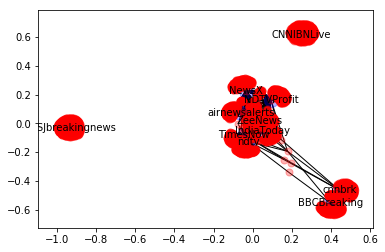

network drawn to network.png
Creating Dump File
Pickle Dump Created Successfully!!
Data Collection Done !!


In [17]:
def main():
    """ Main method. You should not modify this. """

    # twitter connection
    twitter = get_twitter('twitter.cfg')
    print('Established Twitter connection.')
   
    #read News-Channel list from file
    screen_names = read_screen_names('NewsChannel.txt')
    #print('Read screen names: %s' % screen_names)
   
    users = sorted(get_users(twitter, screen_names), key=lambda x: x['screen_name'])
    #print(users)
    print('found %d NewsChannels with screen_names %s' %
           (len(users), str([u['screen_name'] for u in users])))
    

    # get tweets
    Tweets = get_tweets(twitter,users)
    print('Number of Tweets =',len(Tweets))
 
    # get followers for graph creation 
    add_all_Followers(twitter, users)
    
    print('\nFollowers Taken per News-Channel:')
    print_num_Followers(users)

    Follower_counts = count_Followers(users)

    print('Most common Followers:\n%s' % str(Follower_counts.most_common(5)))
   
    print('Followers Overlap:\n%s' % str(Follower_overlap(users)))
    
    # graph creation
    graph = create_graph(users, Follower_counts)
    
    print('Graph type = ',type(graph))
    print('graph has %s nodes and %s edges' % (len(graph.nodes()), len(graph.edges())))

    # draw graph
    draw_network(graph, users, 'network.png')
    print('network drawn to network.png')
    
    # create dump
    create_pickle_dump(users,graph,Tweets)
 
    print('Data Collection Done !!')
if __name__ == '__main__':
    main()

# That's it for now! This should give you an introduction to some of the data we'll study in this course.
